# Creating The model for the Speaker Recognition

In [2]:
import os
import numpy as np
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Set the parent directory for speaker folders
parent_dir = "./Dataset/"

In [8]:
# List of speaker folders
speaker_folders = os.listdir(parent_dir)
speaker_folders = [folder for folder in speaker_folders if folder != ".DS_Store"]
speaker_folders

['Jens_Stoltenberg',
 'Benjamin_Netanyau',
 'Julia_Gillard',
 'Magaret_Tarcher',
 'Nelson_Mandela']

In [9]:
def extract_features(parent_dir, speaker_folders):
    X = []
    y = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)

        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=None, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                
                # Normalize MFCC features
                mfccs = StandardScaler().fit_transform(mfccs)
                
                X.append(mfccs.T)
                y.append(i)

    return np.array(X), np.array(y)

In [10]:
# Extract features and labels
X, y = extract_features(parent_dir, speaker_folders)

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(speaker_folders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [15]:
# Train the model with EarlyStopping
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20


2024-04-21 12:23:24.182881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-21 12:23:24.339051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/150 [..............................] - ETA: 3:07 - loss: 1.6102 - accuracy: 0.3438

2024-04-21 12:23:24.609678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


149/150 [============================>.] - ETA: 0s - loss: 0.5155 - accuracy: 0.7924

2024-04-21 12:23:26.711822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-21 12:23:26.780760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 4s 17ms/step - loss: 0.5147 - accuracy: 0.7927 - val_loss: 0.1776 - val_accuracy: 0.9358
Epoch 2/20
150/150 [==============================] - 2s 13ms/step - loss: 0.2062 - accuracy: 0.9298 - val_loss: 0.1520 - val_accuracy: 0.9408
Epoch 3/20
150/150 [==============================] - 2s 12ms/step - loss: 0.1276 - accuracy: 0.9550 - val_loss: 0.1060 - val_accuracy: 0.9625
Epoch 4/20
150/150 [==============================] - 2s 12ms/step - loss: 0.1222 - accuracy: 0.9552 - val_loss: 0.0854 - val_accuracy: 0.9725
Epoch 5/20
150/150 [==============================] - 2s 13ms/step - loss: 0.1006 - accuracy: 0.9656 - val_loss: 0.1504 - val_accuracy: 0.9533
Epoch 6/20
150/150 [==============================] - 2s 12ms/step - loss: 0.0760 - accuracy: 0.9750 - val_loss: 0.0846 - val_accuracy: 0.9717
Epoch 7/20
150/150 [==============================] - 2s 12ms/step - loss: 0.0590 - accuracy: 0.9806 - val_loss: 0.0760 - val_accuracy: 0.9750
Epoch 8/20

In [16]:
# Check if EarlyStopping triggered
if early_stopping.stopped_epoch > 0:
    print("Early stopping triggered at epoch", early_stopping.stopped_epoch + 1)
else:
    print("Training completed without early stopping")

Early stopping triggered at epoch 11


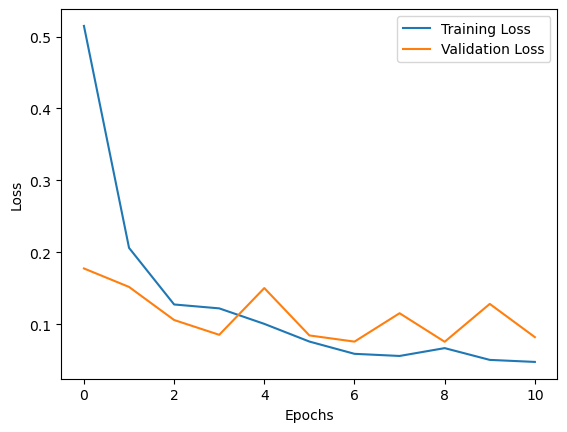

In [17]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

13/47 [=======>......................] - ETA: 0s 

2024-04-21 12:24:21.666270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-21 12:24:21.713398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 1s 12ms/step


In [19]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1}")

Test Evaluation Accuracy: 0.9713524317121919
Weighted F1 Score: 0.9714762076376281


<Axes: >

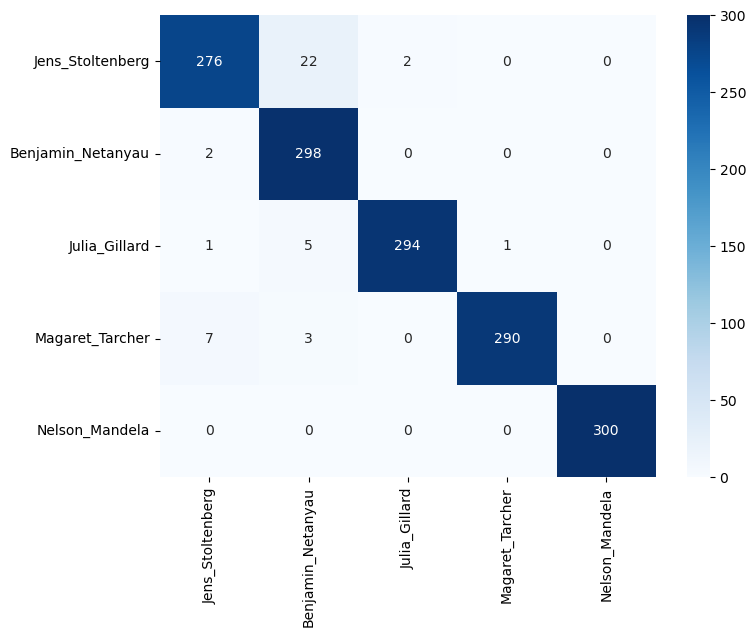

In [21]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

In [24]:
# Save the model
model.save("speaker_recognition_model")

INFO:tensorflow:Assets written to: speaker_recognition_model/assets


INFO:tensorflow:Assets written to: speaker_recognition_model/assets


In [25]:
# Function to extract features from a single .wav file
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=None, duration=1)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs = np.expand_dims(mfccs.T, axis=0)  # Add batch dimension
    return mfccs


In [26]:
# Path to the single .wav file you want to predict
file_path = "./Dataset/Julia_Gillard/1001.wav"

In [27]:
# Extract features from the single .wav file
features = extract_features(file_path)

In [28]:
# Predict the speaker label
predicted_label = np.argmax(model.predict(features), axis=1)[0]

1/1 [==============================] - 2s 2s/step


In [29]:
speaker_names = [
    "Benjamin_Netanyau",
    "Jens_Stoltenberg",
    "Julia_Gillard",
    "Magaret_Tarcher",
    "Nelson_Mandela"
]

In [30]:
predicted_speaker = speaker_names[predicted_label]

In [32]:
print(f"The predicted speaker for the given audio file is: {predicted_speaker}")

The predicted speaker for the given audio file is: Julia_Gillard


# Creating The model for the Text Extraction

In [34]:
import os
import speech_recognition as sr

In [35]:
# Directory containing speaker directories
dataset_path = "./Dataset/"

In [36]:
# List speaker directories
speaker_directories = os.listdir(dataset_path)

In [37]:
# Initialize the recognizer
recognizer = sr.Recognizer()

In [38]:
# Iterate over each speaker directory
for speaker_directory in speaker_directories:
    speaker_path = os.path.join(dataset_path, speaker_directory)
    # Iterate over each audio clip in the speaker directory
    for audio_file in os.listdir(speaker_path):
        if audio_file.endswith(".wav"):
            audio_path = os.path.join(speaker_path, audio_file)
            # Load audio file
            with sr.AudioFile(audio_path) as source:
                audio_data = recognizer.record(source)
                # Transcribe speech using Google Web Speech API
                try:
                    transcription = recognizer.recognize_google(audio_data)
                    print(f"Transcription for {audio_file}: {transcription}")
                except sr.UnknownValueError:
                    print(f"Google Web Speech API could not understand the audio in {audio_file}")
                except sr.RequestError as e:
                    print(f"Could not request results from Google Web Speech API; {e}")

Google Web Speech API could not understand the audio in 1078.wav
Transcription for 1044.wav: choose the
Google Web Speech API could not understand the audio in 1050.wav
Google Web Speech API could not understand the audio in 249.wav
Google Web Speech API could not understand the audio in 275.wav
Google Web Speech API could not understand the audio in 1087.wav
Transcription for 513.wav: today
Google Web Speech API could not understand the audio in 507.wav
Google Web Speech API could not understand the audio in 1093.wav
Transcription for 261.wav: Nahin to has
Transcription for 936.wav: search inside
Google Web Speech API could not understand the audio in 922.wav
Google Web Speech API could not understand the audio in 1246.wav
Transcription for 1252.wav: has
Transcription for 739.wav: I want to join
Google Web Speech API could not understand the audio in 711.wav
Google Web Speech API could not understand the audio in 1285.wav
Transcription for 1291.wav: UN
Transcription for 705.wav: old r

KeyboardInterrupt: 